In this notebook we include some of the graphs or stats from PHEME-9. These are used in the MSc associated with these documents.

# Import

Import necessary packages.

In [ ]:
import pandas as pd
import networkx as nx
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import string
from nltk.stem import WordNetLemmatizer
import warnings

tk = TweetTokenizer(strip_handles=False)
nltk.download('omw-1.4')
nltk.download('wordnet')

nltk.download('stopwords')

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Load data and Prepare Network

Load the data and network. Set paths accordingly.

In [ ]:
path_dataset = 'path_to_dataset'
path_net = 'path_to_net'

In [ ]:
comments = pd.read_json(path_dataset+'comments.json')

In [ ]:
G = nx.read_graphml(path_net + 'followers_info_adding.graphml')

In [ ]:
G_full = G.copy()

In [ ]:
for id, elem in comments[comments['type_content']== 'source'].iterrows():
  # por cada thread
  total_conv = comments[comments['thread_from'] == elem['thread_from']]
  user_dict =  elem['user'] # info del poster
  for idx, el2 in total_conv.iterrows():
    user_dict_this =  el2['user']
    if user_dict['id_str'] != user_dict_this['id_str'] : # no es él mismo
      if not G_full.has_node(user_dict_this['id_str']):
        G_full.add_node(user_dict_this['id_str'])
      if not G_full.has_node(user_dict['id_str']):
        G_full.add_node(user_dict['id_str'])
      if not nx.has_path(G_full, user_dict_this['id_str'], user_dict['id_str']): # si no hay camino (dirigido)
        G_full.add_edge(user_dict_this['id_str'], user_dict['id_str'])

In [ ]:
print(f"Nodes: {len(G_full.nodes())}, edges: {len(G_full.edges())}")
print(f"Nodes (before): {len(G.nodes())}, edges: {len(G.edges())}")

Nodes: 55147, edges: 106016
Nodes (before): 43732, edges: 92607


# Stats on annotation

We check some stats from the annotation of the dataset.

## User Info

Check median.

In [ ]:
comments['followers_count'] = comments['user'].apply(lambda x: x['followers_count'])
comments['followees'] = comments['user'].apply(lambda x: x['friends_count'])
comments['listed_count'] = comments['user'].apply(lambda x: x['listed_count'])
comments['follower_followee'] = comments.apply(lambda x: 0 if x['followees']== 0 else x['followers_count'] / x['followees'],axis=1)

In [ ]:
comments['listed_count']

0        4085
1          68
2          20
3           0
4          68
         ... 
66076       4
66077       1
66078       0
66079       9
66080       9
Name: listed_count, Length: 66081, dtype: int64

Show distribution of followers, extremely skewed. We have exponential. Some extremely influential nodes, other randoms.

In [ ]:
from scipy.stats import zscore

comments['zscore_follower_followee'] = zscore(comments.follower_followee)
comments['zscore_listed_count'] = zscore(comments.listed_count)
comments['zscore_followees'] = zscore(comments.followees)
comments['zscore_followers_count'] = zscore(comments.followers_count)

In [ ]:
comments['norm_z_listed_count'] = (comments['zscore_listed_count'] - comments['zscore_listed_count'].min()) / (comments['zscore_listed_count'].max() - comments['zscore_listed_count'].min())
comments['norm_z_follower_followee'] = (comments['zscore_follower_followee'] - comments['zscore_follower_followee'].min()) / (comments['zscore_follower_followee'].max() - comments['zscore_follower_followee'].min())

comments['norm_z_followees'] = (comments['zscore_followees'] - comments['zscore_followees'].min()) / (comments['zscore_followees'].max() - comments['zscore_followees'].min())
comments['norm_followers_count'] = (comments['zscore_followers_count'] - comments['zscore_followers_count'].min()) / (comments['zscore_followers_count'].max() - comments['zscore_followers_count'].min())

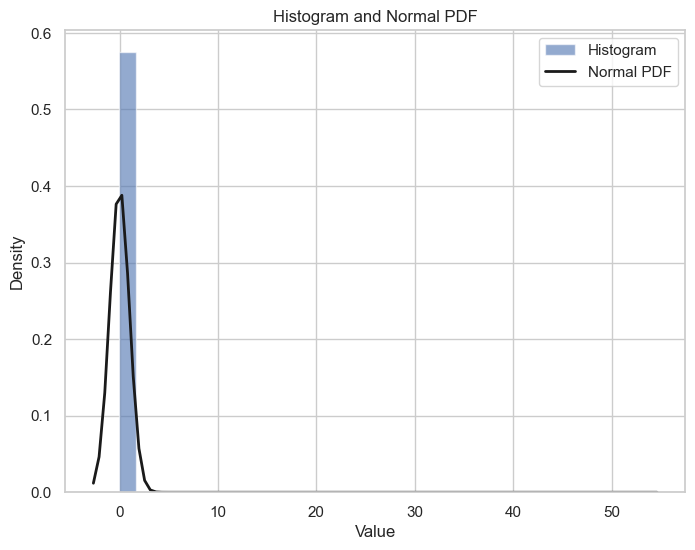

In [ ]:
from scipy import stats
plt.figure(figsize=(8, 6))
plt.hist(comments['zscore_listed_count'], bins=30, density=True, alpha=0.6, color='b', label='Histogram')  # Plot histogram
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(comments['zscore_listed_count']), np.std(comments['zscore_listed_count']))
plt.plot(x, p, 'k', linewidth=2, label='Normal PDF')
plt.title('Histogram and Normal PDF')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
sources_stats_toed['listed_counts'] = sources_stats_toed['id'].apply(lambda x: comments[comments['edit_thread'] == x].iloc[0]['listed_count'])

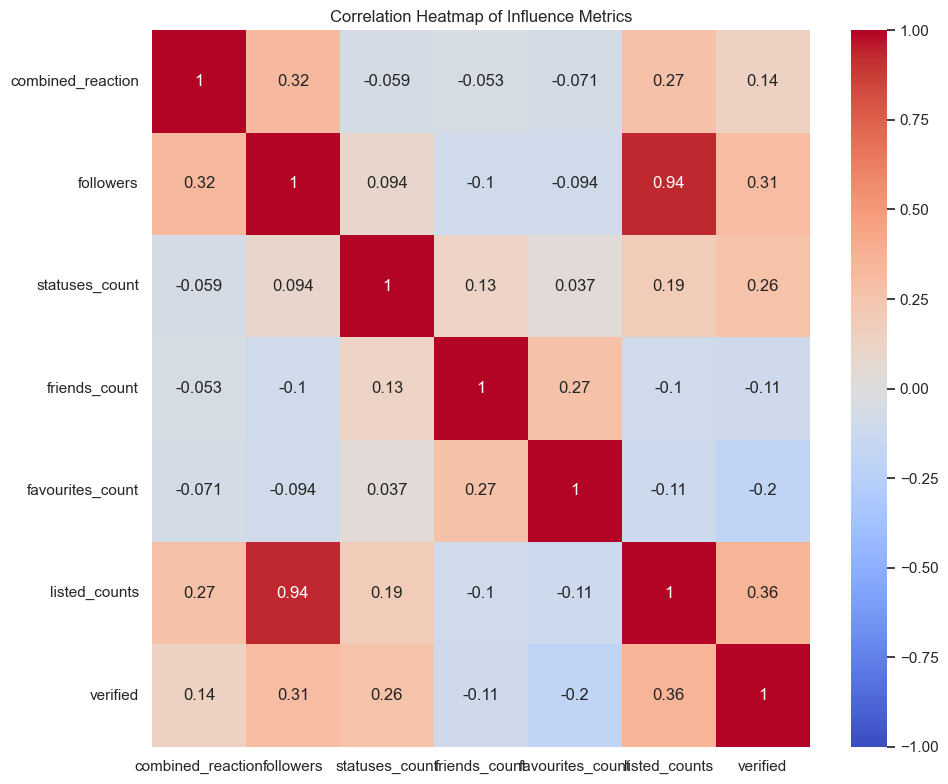

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(sources_stats_toed[['combined_reaction', 'followers', 'statuses_count', 'friends_count', 'favourites_count', 'listed_counts', 'verified']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Influence Metrics')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Tweet Emotion

Check the emotions from users.

In [ ]:
emo = pd.read_json(path_dataset+'comments_emotions.json')

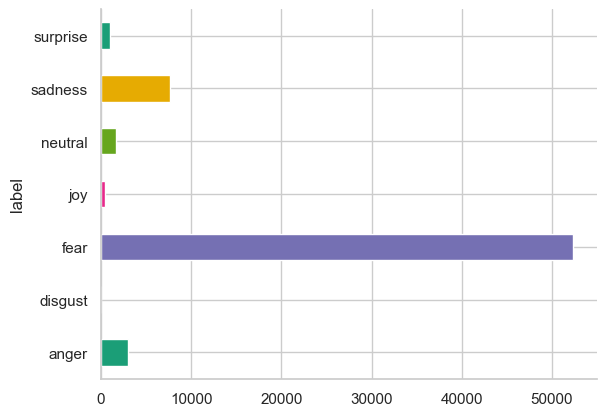

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
emo.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

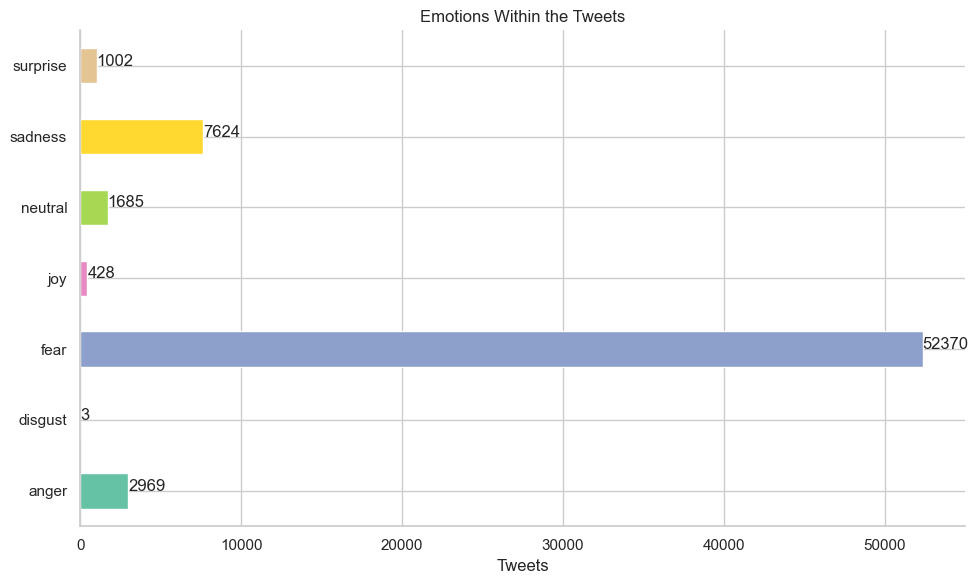

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
emo.groupby('label').size().plot(kind='barh', color=sns.color_palette('Set2'))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Values
for index, value in enumerate(emo.groupby('label').size()):
    plt.text(value, index, str(value))

plt.xlabel('Tweets')
plt.ylabel('')
plt.title('Emotions Within the Tweets')
plt.tight_layout()
plt.show()

Group by theme, how many specific topics are there?

In [ ]:
df_k[['type_content']]

type_content
60943       source
60944     reaction
60945     reaction
60946      retweet
60947      retweet
...            ...
61028      retweet
61029      retweet
61030      retweet
61031      retweet
61032      retweet

[90 rows x 1 columns]

In [ ]:
se = [['user_id', 'type_content']]
df_k = comments[comments['thread_from'] == 544358564484378624]
df_k[df_k['type_content'] == 'source'].iloc[0]['user']

{'follow_request_sent': False,
 'profile_use_background_image': True,
 'profile_text_color': '333333',
 'default_profile_image': False,
 'id': 28785486,
 'profile_background_image_url_https': 'https://pbs.twimg.com/profile_background_images/441965491024719872/pAv-lzCZ.jpeg',
 'verified': True,
 'profile_location': None,
 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/528328276414971904/6UHQeTXS_normal.png',
 'profile_sidebar_fill_color': 'DDEEF6',
 'entities': {'url': {'urls': [{'url': 'http://t.co/v7GWW7yYST',
     'indices': [0, 22],
     'expanded_url': 'http://ABCNews.com',
     'display_url': 'ABCNews.com'}]},
  'description': {'urls': []}},
 'followers_count': 3775576,
 'profile_sidebar_border_color': 'FFFFFF',
 'id_str': '28785486',
 'profile_background_color': '6E8EB5',
 'listed_count': 36870,
 'is_translation_enabled': True,
 'utc_offset': -18000,
 'statuses_count': 99519,
 'description': 'See the whole picture with @ABC News. Tweets from the Social Desk: @Sp

In [ ]:
comments['user_id'] = comments['user'].apply(lambda x: x['id_str'])

In [ ]:
sources_stats_toed = pd.read_json(path_dataset+'source_stats_final.json')

In [ ]:
len(sources_stats_toed['category'].unique())

137

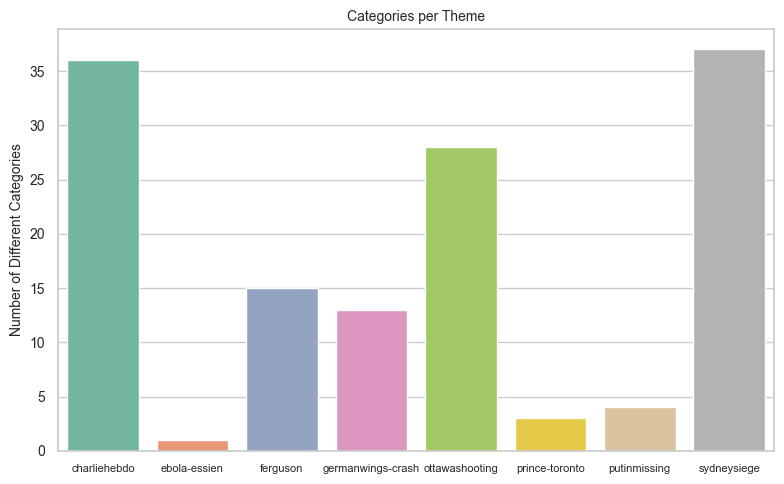

In [ ]:
# Group by theme and count the number of cats
unique_categories_per_theme = sources_stats_toed.groupby('theme')['category'].nunique().reset_index()
unique_categories_per_theme.columns = ['event', 'unique_category_count']

sns.set(style="whitegrid")

plt.fontsize = 8
plt.figure(figsize=(8, 5))
barplot = sns.barplot(
    x='event',
    y='unique_category_count',
    data=unique_categories_per_theme,
    palette='Set2'
)

barplot.set_title('Categories per Theme', fontsize=10)
barplot.set_ylabel('Number of Different Categories', fontsize=10)
barplot.set_xlabel('', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=8)


plt.tight_layout()
plt.show()

In [ ]:
comments['theme'].value_counts()

theme
charliehebdo         23569
ottawashooting       16456
sydneysiege          12876
ferguson              7712
germanwings-crash     4525
ebola-essien           407
putinmissing           309
prince-toronto         227
Name: count, dtype: int64

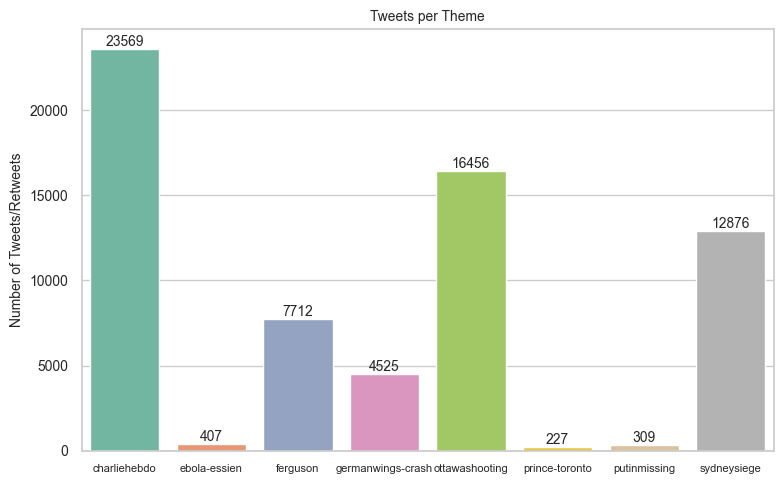

In [ ]:
unique_categories_per_theme = comments['theme'].value_counts().reset_index()
unique_categories_per_theme.columns = ['event', 'count']
des_o =[e.get_text() for e in list(barplot.get_xticklabels())]

plt.fontsize = 8
plt.figure(figsize=(8, 5))
barplot = sns.barplot(
    x='event',
    y='count',
    order = des_o,
    data=unique_categories_per_theme,
    palette='Set2'
)

barplot.set_title('Tweets per Theme', fontsize=10)
barplot.set_ylabel('Number of Tweets/Retweets', fontsize=10)
barplot.set_xlabel('', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=8)

for index, row in unique_categories_per_theme.iterrows():
    if row['event'] in des_o:
        barplot.text(
            x=des_o.index(row['event']),
            y=row['count'],
            s=f'{row["count"]}',
            ha='center',
            va='bottom',
            fontsize=10
        )


plt.tight_layout()
plt.show()

In [ ]:
# Group by th and cat
grouped_df = sources_stats_toed.groupby(['theme', 'category']).size().unstack(fill_value=0)

# Plot
grouped_df.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.title('Number of Categories per Theme')
plt.xlabel('Theme')
plt.ylabel('Count')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show
plt.show()

## Stats on textual

Get some stats on textual data.

In [ ]:
comments.groupby(['type_content']).size().reset_index()

type_content      0
0     reaction   4796
1      retweet  60988
2       source    297

We use the source and reactions comments only (not RTs) for stats.

In [ ]:
abc = comments[comments['type_content'] == 'source']['text'].apply(lambda x: len(x))
abc.mean()

119.88888888888889

In [ ]:
abc = comments[comments['type_content'] == 'reaction']['text'].apply(lambda x: len(x))
abc.mean()

92.65179316096747

Process the text to differentiate # from @...

In [ ]:
def preprocess_eng(text_line, stop_words):

    # Tokenize
    text_token = tk.tokenize(text_line)

    # Hashtags, handles and websites
    cleaned_text = [word for word in text_token if not word.startswith('http') and ( not word.startswith("@")) and (not word.startswith("#"))]

    #Lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in cleaned_text]

    return " ".join(cleaned_text)

In [ ]:
stop_words = set(stopwords.words('english'))
abc = comments[comments['type_content'] == 'source']['text'].copy()
abc['proc'] = abc.apply(lambda x: preprocess_eng(x, stop_words))

abc2 = comments[comments['type_content'] == 'reaction']['text'].copy()
abc2['proc'] = abc2.apply(lambda x: preprocess_eng(x, stop_words))

Average lengths of texts only.

In [ ]:
abca = abc['proc'].apply(lambda x: len(x))
abca.mean()

89.44444444444444

In [ ]:
abcb = abc2['proc'].apply(lambda x: len(x))
abcb.mean()

66.8012927439533

Distribution of fake news.


In [ ]:
comments.groupby('theme')['misinformation'].mean()

theme
charliehebdo_good    0.124358
ebola-essien         1.000000
ferguson             0.000000
germanwings-crash    0.127735
ottawashooting       0.253707
prince-toronto       1.000000
putinmissing         0.061489
sydneysiege          0.137620
Name: misinformation, dtype: float64

In [ ]:
comments.groupby('theme')['true'].mean()

theme
charliehebdo_good    0.620179
ebola-essien              NaN
ferguson             0.043568
germanwings-crash    0.700331
ottawashooting       0.584225
prince-toronto            NaN
putinmissing              NaN
sydneysiege          0.737651
Name: true, dtype: float64

In [ ]:
comments['theme'].value_counts()

theme
charliehebdo_good    23569
ottawashooting       16456
sydneysiege          12876
ferguson              7712
germanwings-crash     4525
ebola-essien           407
putinmissing           309
prince-toronto         227
Name: count, dtype: int64

Opinion supports.

In [ ]:
comments.support.value_counts()

support
supporting        63361
denying            1396
underspecified     1324
Name: count, dtype: int64

In [ ]:
comments[comments['support'] == 'underspecified']['text'].iloc[8]

'@BBCWorld JeSuisCharlie http://t.co/nZSI9NkxmA'

## Stats on diffusion

When it diffuses the most or faster.


Variation of RTs and comments, and based on Real/Fake. (Here we see >1 interaction, which problematic for many models and their state-based approaches).


In [ ]:
path_to_saved = 'path_to_diffusion_dataset'

Get the example of one tweet and its diffusion. We plot it.

In [ ]:
real_di = pd.read_json(path_to_saved+'552783667052167168.json')

In [ ]:
ticks = []
tot = []

for el in real_di['diffusion']:
  ticks.append(el['tick'])
  tot.append(el['infected'] + el['debunker'])

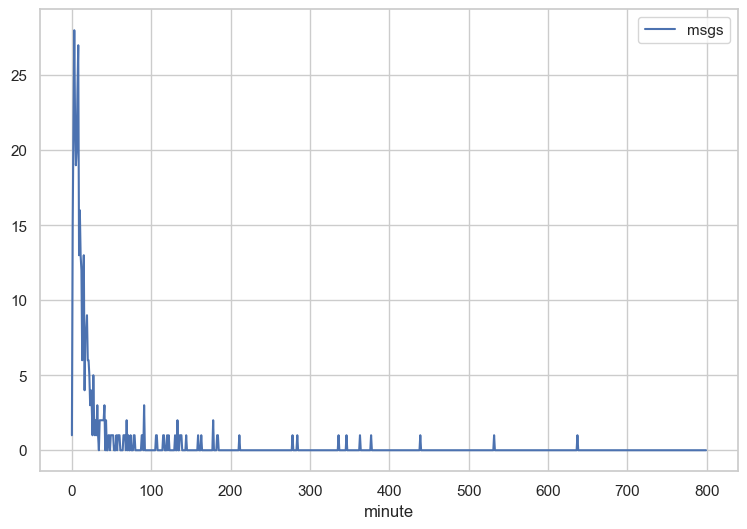

In [ ]:
df = pd.DataFrame(data={'minute': ticks[:800],'msgs' :tot[:800]})

# Plot the data
df.plot(x='minute', y='msgs', figsize=(9, 6))

# Show
plt.show()

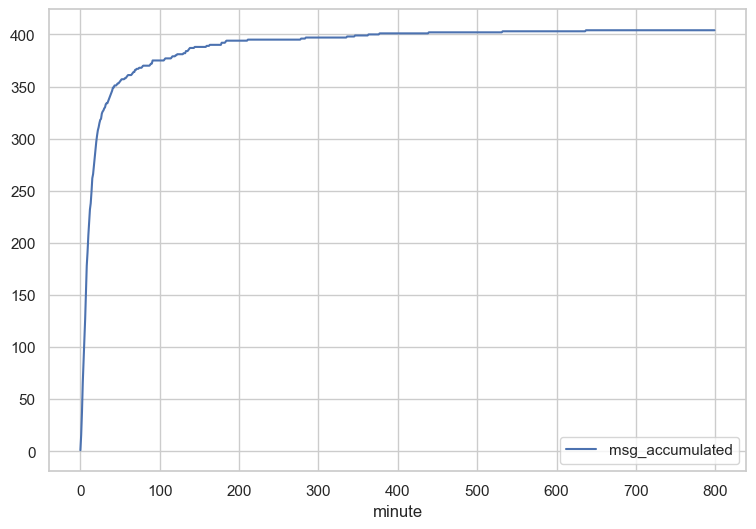

In [ ]:
df = pd.DataFrame(data={'minute': ticks[:800],'msgs' :tot[:800]})
df['msg_accumulated'] = df['msgs'].cumsum()

# Plot the data
df.plot(x='minute', y='msg_accumulated', figsize=(9, 6))

# Show
plt.show()

Now we check the most shared news in relation to its misinfo/true category.

In [ ]:
sources_stats_toed.sort_values('combined_reaction', ascending=False)[['misinformation', 	'true']]

misinformation  true
67                0   1.0
72                0   1.0
120               0   1.0
69                0   1.0
27                1   0.0
..              ...   ...
288               0   NaN
285               1   NaN
137               1   0.0
123               1   0.0
294               0   NaN

[297 rows x 2 columns]

In [ ]:
sources_stats_toed.iloc[27]

index                                                                   0
is_rumour                                                          rumour
theme                                                        charliehebdo
id                                                     553152395371630592
is_turnaround                                                         0.0
misinformation                                                          1
true                                                                  0.0
category                Banksy drew a tribute to Charlie Hebdo featuri...
source_support                                                 supporting
source_evidence                                                 url-given
source_certainty                                                  certain
num_rts                                                              1191
num_react                                                              21
react_agree                           

In [ ]:
sources_stats_toed.iloc[67]

index                                                                   0
is_rumour                                                          rumour
theme                                                        charliehebdo
id                                                     553587013409325058
is_turnaround                                                         0.0
misinformation                                                          0
true                                                                  1.0
category                The hostage in Dammartin has been freed follow...
source_support                                                 supporting
source_evidence                                               no-evidence
source_certainty                                                  certain
num_rts                                                              2731
num_react                                                              34
react_agree                           

We load
553152395371630592, 553587013409325058. Real vs fake, for the same topic (Charlie Hebdo).

In [ ]:
real_di_fake = pd.read_json(path_to_saved+'553152395371630592.json')

In [ ]:
real_di_real = pd.read_json(path_to_saved+'553587013409325058.json')

In [ ]:
ticks_r = []
tot_r = []

for el in real_di_real['diffusion']:
  ticks_r.append(el['tick'])
  tot_r.append(el['infected'] + el['debunker'])

ticks_f = []
tot_f = []

for el in real_di_fake['diffusion']:
  ticks_f.append(el['tick'])
  tot_f.append(el['infected'] + el['debunker'])

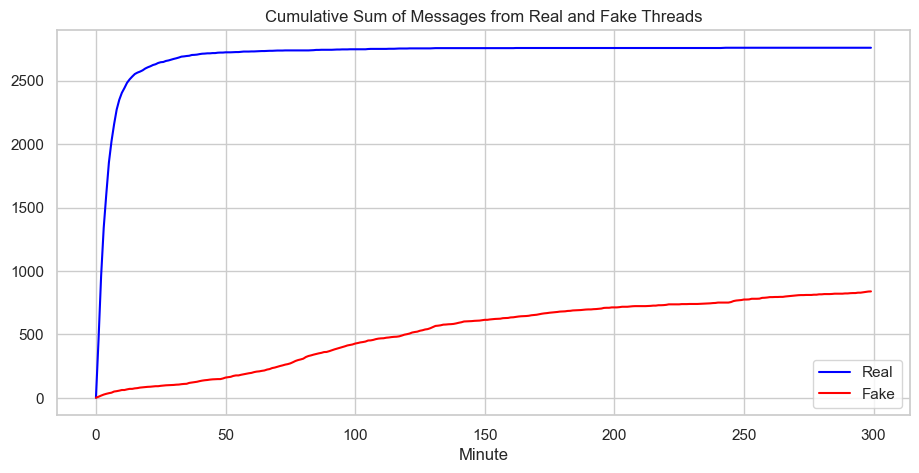

<Figure size 1600x600 with 0 Axes>

In [ ]:
df = pd.DataFrame(data={'minute': ticks_r[:300],'msgs_real' :tot_r[:300], 'msgs_fake' :tot_f[:300]})
df['msg_acc_real'] = df['msgs_real'].cumsum()
df['msg_acc_fake'] = df['msgs_fake'].cumsum()

# Plot
fig, ax = plt.subplots(figsize=(11, 5))
df.plot(x='minute', y='msg_acc_real', label='Real', color='blue', ax=ax)
df.plot(x='minute', y='msg_acc_fake', label='Fake', color='red', ax=ax)

# Show
plt.xlabel('Minute')
plt.title('Cumulative Sum of Messages from Real and Fake Threads')
plt.legend()
plt.figure(figsize=(16, 6))
plt.show()